# Trader Behavior Insights — Bitcoin Sentiment vs Hyperliquid Trader Performance
Objective: Explore relationship between market sentiment (Fear/Greed) and trader performance (closedPnL, win rate, leverage usage) using the provided datasets.
References: Assignment instructions PDF. :contentReference[oaicite:1]{index=1}


In [1]:
# Install necessary libraries
!pip install -q gdown shap lightgbm statsmodels

# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import shap
import statsmodels.api as sm

# Create directories for outputs and CSV files
os.makedirs('/content/outputs', exist_ok=True)
os.makedirs('/content/csv_files', exist_ok=True)

# Set default figure size for plots
plt.rcParams['figure.figsize'] = (10,5)

In [2]:
# Define Google Drive file IDs for the datasets
TRADER_FILE_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
SENT_FILE_ID   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

# Download the datasets from Google Drive using gdown
import gdown
gdown.download(id=TRADER_FILE_ID, output='/content/historical_data.csv', quiet=False)
gdown.download(id=SENT_FILE_ID, output='/content/fear_greed_index.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 92.3MB/s]


'/content/fear_greed_index.csv'

In [3]:
# Load the downloaded CSV files into pandas DataFrames
trades = pd.read_csv('/content/historical_data.csv', low_memory=False)
sent = pd.read_csv('/content/fear_greed_index.csv', low_memory=False)

# Print the shapes and column names of the DataFrames
print("Trades shape:", trades.shape)
print("Sentiment shape:", sent.shape)
print("\nTrades columns:\n", trades.columns.tolist())
print("\nSent sample:")
# Display the first few rows of the trades DataFrame
display(trades.head())
print("\nSentiment sample:")
# Display the first few rows of the sentiment DataFrame
display(sent.head())

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)

Trades columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sent sample:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



Sentiment sample:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
# Clean column names by stripping whitespace, converting to lowercase, and replacing spaces with underscores
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sent.columns   = sent.columns.str.strip().str.lower().str.replace(' ', '_')

# Identify potential time columns in the trades DataFrame
time_cols = [c for c in trades.columns if 'time' in c or 'timestamp' in c or 'created' in c]
print("Possible time columns:", time_cols)

# Convert identified time columns to datetime objects, handling errors by coercing invalid parsing to NaT
if 'time' in trades.columns:
    trades['time'] = pd.to_datetime(trades['time'], errors='coerce', utc=True)
elif time_cols:
    trades['time'] = pd.to_datetime(trades[time_cols[0]], errors='coerce', utc=True)
else:
    trades['time'] = pd.NaT

# Convert the date column in the sentiment DataFrame to datetime objects and then to date objects
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date
else:
    sent.iloc[:,0] = pd.to_datetime(sent.iloc[:,0], errors='coerce')
    sent = sent.rename(columns={sent.columns[0]:'date'})
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date

# Extract the date part from the 'time' column in the trades DataFrame
trades['trade_date'] = trades['time'].dt.date

# Convert specified columns in the trades DataFrame to numeric, coercing errors to NaN
for col in ['closedpnl','size','leverage','execution_price','price','notional']:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

# Display the heads of the processed trades and sentiment DataFrames
display(trades.head())
display(sent.head())

Possible time columns: ['timestamp_ist', 'timestamp']


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,time,trade_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [8]:
# Print unique values in the 'event' column if it exists
if 'event' in trades.columns:
    print("Unique events:", trades['event'].dropna().unique()[:20])

# Filter the trades DataFrame to include only rows where 'closed_pnl' is not NaN
trades = trades[~trades['closed_pnl'].isna()].copy()
# Print the shape of the trades DataFrame after filtering
print("After filtering closedPnL present:", trades.shape)

After filtering closedPnL present: (211224, 19)


In [10]:
# Calculate 'notional' if it doesn't exist based on 'size' and 'execution_price' or 'price'
if 'notional' not in trades.columns:
    if 'size' in trades.columns and 'execution_price' in trades.columns:
        trades['notional'] = trades['size'] * trades['execution_price']
    elif 'size' in trades.columns and 'price' in trades.columns:
        trades['notional'] = trades['size'] * trades['price']
    else:
        trades['notional'] = np.nan

# Create 'is_profit' column (1 if closed_pnl > 0, 0 otherwise)
trades['is_profit'] = (trades['closed_pnl'] > 0).astype(int)
# Create 'abs_pnl' column (absolute value of closed_pnl)
trades['abs_pnl'] = trades['closed_pnl'].abs()

# Calculate 'pnl_pct' (closed_pnl as a percentage of notional)
trades['pnl_pct'] = trades['closed_pnl'] / (trades['notional'].abs() + 1e-9)

# Convert 'side' column to lowercase string if it exists
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.lower()

In [12]:
# Print available columns in the trades DataFrame
print("Available columns in trades:", trades.columns.tolist())

# Identify the leverage column
leverage_col = None
for col in trades.columns:
    if 'leverage' in col.lower():
        leverage_col = col
        print(f"Using leverage column: {col}")
        break

# Define aggregation dictionary for daily metrics
agg_dict = {
    'trade_count': ('account','count'),
    'total_pnl': ('closed_pnl','sum') if 'closed_pnl' in trades.columns else ('closed_pnl','sum'),
    'avg_pnl': ('closed_pnl','mean') if 'closed_pnl' in trades.columns else ('closed_pnl','mean'),
    'median_pnl': ('closed_pnl','median') if 'closed_pnl' in trades.columns else ('closed_pnl','median'),
    'win_rate': ('is_profit','mean'),
    'total_volume': ('notional','sum'),
    'mean_abs_pnl': ('abs_pnl','mean')
}

# Add average leverage to aggregation dictionary if leverage column exists
if leverage_col:
    agg_dict['avg_leverage'] = (leverage_col, 'mean')

# Group trades by trade_date and aggregate using the defined dictionary
daily = trades.groupby('trade_date').agg(**agg_dict).reset_index().rename(columns={'trade_date':'date'})

# Ensure the 'date' column is in date format
daily['date'] = pd.to_datetime(daily['date']).dt.date

# Merge daily metrics with sentiment data on date
daily = daily.merge(sent[['date','classification']], on='date', how='left')
# Fill missing sentiment classifications with 'Unknown'
daily['classification'] = daily['classification'].fillna('Unknown')

# Display the first 10 rows of the daily metrics DataFrame
display(daily.head(10))
# Save the daily metrics DataFrame to a CSV file
daily.to_csv('/content/csv_files/daily_metrics.csv', index=False)

Available columns in trades: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'time', 'trade_date', 'notional', 'is_profit', 'abs_pnl', 'pnl_pct']


,date,trade_count,total_pnl,avg_pnl,median_pnl,win_rate,total_volume,mean_abs_pnl,classification
0,2023-01-05,3,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Fear
1,2023-05-12,9,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Neutral
2,2024-01-01,18,-129.531460,-7.196192,0.00000,0.055556,0.0,38.493644,Greed
3,2024-01-02,6,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Greed
4,2024-01-03,137,8244.241409,60.176945,27.04384,0.934307,0.0,60.176945,Greed
5,2024-01-04,77,2507.963406,32.570953,0.54675,0.545455,0.0,33.607070,Greed
6,2024-01-05,14,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Greed
7,2024-01-06,25,91.510419,3.660417,0.00000,0.360000,0.0,3.660417,Greed
8,2024-01-07,64,5065.839308,79.153739,0.00000,0.406250,0.0,79.153739,Greed
9,2024-01-08,57,167.080017,2.931228,0.00000,0.070175,0.0,3.287961,Greed


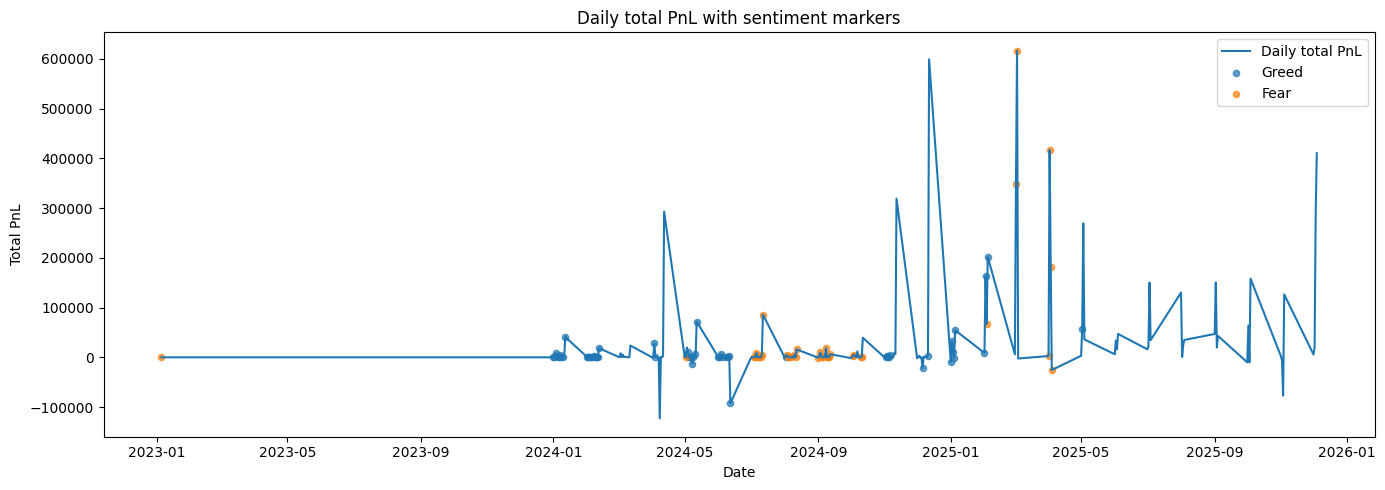

In [13]:
# Import matplotlib dates for better date formatting on plots
import matplotlib.dates as mdates

# Create a copy of the daily DataFrame for plotting and convert date to datetime objects
daily_plot = daily.copy()
daily_plot['date_dt'] = pd.to_datetime(daily_plot['date'])

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(14,5))
# Plot daily total PnL over time
ax.plot(daily_plot['date_dt'], daily_plot['total_pnl'], label='Daily total PnL')
# Scatter plot sentiment markers on the PnL line
for cls, color in [('Greed','green'), ('Fear','red')]:
    mask = daily_plot['classification']==cls
    ax.scatter(daily_plot.loc[mask,'date_dt'], daily_plot.loc[mask,'total_pnl'], label=cls, s=20, alpha=0.7)
# Set plot title and labels
ax.set_title('Daily total PnL with sentiment markers')
ax.set_xlabel('Date')
ax.set_ylabel('Total PnL')
ax.legend()
# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('/content/outputs/time_series_pnl_sentiment.png', dpi=150)
# Show the plot
plt.show()

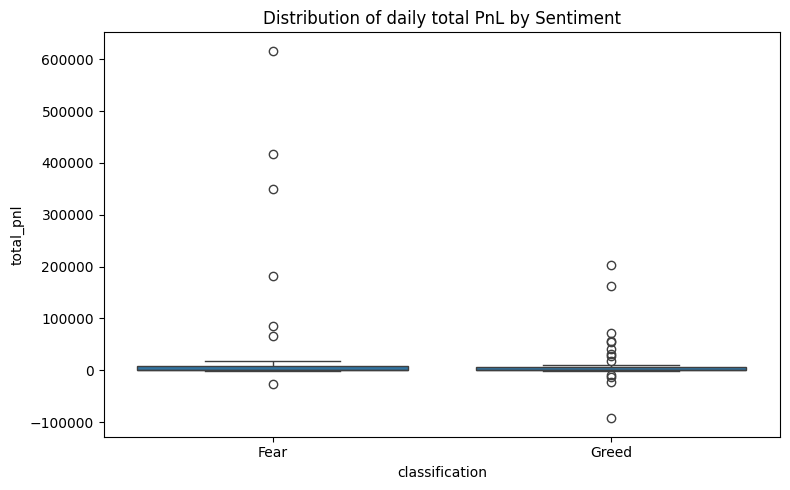

In [14]:
# Create a boxplot to visualize the distribution of daily total PnL by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='total_pnl', data=daily[daily['classification'].isin(['Fear','Greed'])])
# Set plot title and labels
plt.title('Distribution of daily total PnL by Sentiment')
plt.xticks(rotation=0)
# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('/content/outputs/boxplot_daily_pnl_by_sentiment.png', dpi=150)
# Show the plot
plt.show()

,classification,mean,count,std
0,Fear,0.348071,37,0.289032
1,Greed,0.362415,56,0.285226


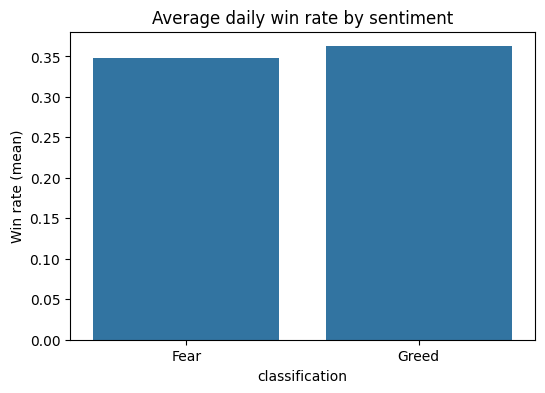

In [15]:
# Aggregate daily win rate by sentiment classification (Fear and Greed)
agg_wr = daily[daily['classification'].isin(['Fear','Greed'])].groupby('classification')['win_rate'].agg(['mean','count','std']).reset_index()
# Display the aggregated win rate data
display(agg_wr)

# Create a bar plot to visualize the average daily win rate by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='mean', data=agg_wr)
# Set plot title and labels
plt.title('Average daily win rate by sentiment')
plt.ylabel('Win rate (mean)')
# Save the plot
plt.savefig('/content/outputs/win_rate_by_sentiment.png', dpi=150)
# Show the plot
plt.show()

In [16]:
# Extract total PnL for Fear and Greed sentiment days, dropping NaN values
fear = daily.loc[daily['classification']=='Fear', 'total_pnl'].dropna()
greed = daily.loc[daily['classification']=='Greed', 'total_pnl'].dropna()
# Print the number of samples for each sentiment
print("Samples: Fear:", len(fear), "Greed:", len(greed))

# Perform Mann-Whitney U test to compare PnL distributions between Fear and Greed days
u_stat, p_mw = mannwhitneyu(fear, greed, alternative='two-sided')
# Print the p-value from the Mann-Whitney U test
print("Mann-Whitney U p-value:", p_mw)

# Perform an independent samples t-test to compare the means of PnL between Fear and Greed days
t_stat, p_t = ttest_ind(fear, greed, equal_var=False, nan_policy='omit')
# Print the p-value from the t-test
print("t-test p-value:", p_t)

# Define a function to calculate Cohen's d effect size
def cohens_d(x,y):
    nx, ny = len(x), len(y)
    dof = nx+ny-2
    pooled = np.sqrt(((nx-1)*np.var(x,ddof=1) + (ny-1)*np.var(y,ddof=1)) / dof)
    return (np.mean(x)-np.mean(y)) / pooled

# Calculate and print Cohen's d between Greed and Fear PnL
try:
    d = cohens_d(greed, fear)
    print("Cohen's d (Greed - Fear):", d)
except Exception as e:
    print("Cohen's d could not be computed:", e)

Samples: Fear: 37 Greed: 56
Mann-Whitney U p-value: 0.4787979897718182
t-test p-value: 0.10585133025087051
Cohen's d (Greed - Fear): -0.41756721131924907


   lag      corr
0    0 -0.133985
1    1 -0.065015
2    2 -0.094307
3    3 -0.054638
4    4 -0.110088
5    5  0.045948
6    6  0.085386
7    7  0.029138


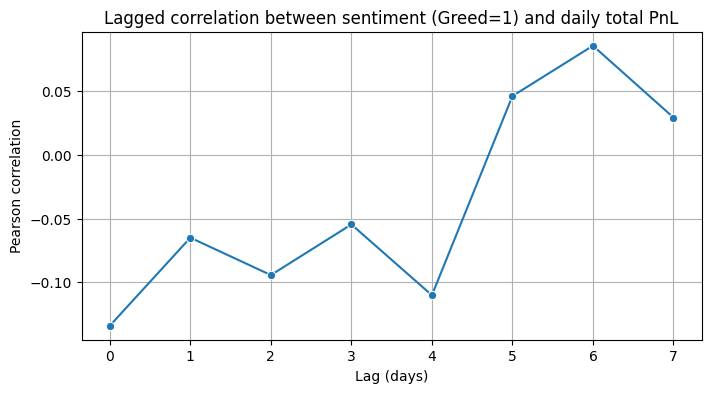

In [17]:
# Sort the daily DataFrame by date
daily_sorted = daily.sort_values('date')
# Create a binary sentiment column (1 for Greed, 0 otherwise)
daily_sorted['sent_bin'] = (daily_sorted['classification']=='Greed').astype(int)

# Calculate lagged correlations between sentiment and total PnL
corrs = []
for lag in range(0,8):
    col = f'sent_lag_{lag}'
    # Create lagged sentiment column
    daily_sorted[col] = daily_sorted['sent_bin'].shift(lag)
    # Create a temporary DataFrame with lagged sentiment and total PnL, dropping NaNs
    tmp = daily_sorted[[col,'total_pnl']].dropna()
    # Calculate Pearson correlation if there are enough samples
    if tmp.shape[0] > 5:
        corr = tmp['total_pnl'].corr(tmp[col])
    else:
        corr = np.nan
    corrs.append((lag, corr))

# Create a DataFrame from the lagged correlations
corr_df = pd.DataFrame(corrs, columns=['lag','corr'])
# Print the correlation DataFrame
print(corr_df)
# Plot the lagged correlations
plt.figure(figsize=(8,4))
sns.lineplot(x='lag', y='corr', data=corr_df, marker='o')
# Set plot title and labels
plt.title('Lagged correlation between sentiment (Greed=1) and daily total PnL')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson correlation')
plt.grid(True)
# Save the plot
plt.savefig('/content/outputs/lagged_correlation.png', dpi=150)
# Show the plot
plt.show()

In [20]:
# Print available columns in the trades DataFrame
print("Columns available in trades:", trades.columns.tolist())

# Identify the closed PnL column
closedpnl_col = None
for col in trades.columns:
    if 'closed' in col.lower() and 'pnl' in col.lower():
        closedpnl_col = col
        print(f"Using PnL column: {col}")
        break

# Identify the leverage column
leverage_col = None
for col in trades.columns:
    if 'leverage' in col.lower():
        leverage_col = col
        print(f"Using leverage column: {col}")
        break

# Define aggregation dictionary for account-level metrics
agg_dict = {
    'total_pnl': (closedpnl_col, 'sum'),
    'trade_count': (closedpnl_col, 'count'),
    'win_rate': ('is_profit', 'mean')
}

# Add average leverage to aggregation dictionary if leverage column exists
if leverage_col:
    agg_dict['avg_leverage'] = (leverage_col, 'mean')

# Group trades by account and aggregate using the defined dictionary
acct_agg = trades.groupby('account').agg(**agg_dict).reset_index()

# Calculate the 90th and 10th percentiles of total PnL to define top and bottom accounts
q90 = acct_agg['total_pnl'].quantile(0.90)
q10 = acct_agg['total_pnl'].quantile(0.10)
# Get the list of top and bottom account IDs
top_accounts = acct_agg[acct_agg['total_pnl'] >= q90]['account'].tolist()
bottom_accounts = acct_agg[acct_agg['total_pnl'] <= q10]['account'].tolist()

# Define a function to calculate daily metrics for a given cohort of accounts
def cohort_metrics(accounts, name):
    # Filter trades for the specified accounts
    df = trades[trades['account'].isin(accounts)]
    # Define aggregation dictionary for daily cohort metrics
    agg_d = {
        'total_pnl': (closedpnl_col, 'sum'),
        'win_rate': ('is_profit', 'mean'),
        'trade_count': (closedpnl_col, 'count')
    }
    # Add average leverage if leverage column exists
    if leverage_col:
        agg_d['avg_leverage'] = (leverage_col, 'mean')

    # Group cohort trades by trade_date and aggregate
    daily_c = df.groupby('trade_date').agg(**agg_d).reset_index().rename(columns={'trade_date': 'date'})
    # Ensure date column is in date format
    daily_c['date'] = pd.to_datetime(daily_c['date']).dt.date
    # Merge with sentiment data
    merged = daily_c.merge(sent[['date','classification']], on='date', how='left')

    # Group merged data by classification and calculate mean metrics
    result = merged.groupby('classification').agg({
        'total_pnl': 'mean',
        'win_rate': 'mean',
        'trade_count': 'mean'
    }).rename(columns={'total_pnl': 'mean_total_pnl'}).reset_index()

    # Merge average leverage if it exists
    if leverage_col and 'avg_leverage' in merged.columns:
        lev = merged.groupby('classification')['avg_leverage'].mean().reset_index()
        result = result.merge(lev, on='classification', how='left')

    return result

# Calculate and display metrics for top and bottom account cohorts
top_metrics = cohort_metrics(top_accounts, 'top')
bottom_metrics = cohort_metrics(bottom_accounts, 'bottom')

display(top_metrics)
display(bottom_metrics)

# Save cohort metrics to CSV files
top_metrics.to_csv('/content/csv_files/top_accounts_sentiment_metrics.csv', index=False)
bottom_metrics.to_csv('/content/csv_files/bottom_accounts_sentiment_metrics.csv', index=False)

Columns available in trades: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'time', 'trade_date', 'notional', 'is_profit', 'abs_pnl', 'pnl_pct']
Using PnL column: closed_pnl


,classification,mean_total_pnl,win_rate,trade_count
0,Extreme Fear,903.638643,0.295678,209.000000
1,Extreme Greed,36958.202904,0.208989,45.481481
2,Fear,58406.077313,0.294056,222.950000
3,Greed,17301.582149,0.378701,110.193548
4,Neutral,-87.860094,0.223983,64.200000


,classification,mean_total_pnl,win_rate,trade_count
0,Extreme Fear,0.000000,0.000000,114.000000
1,Extreme Greed,744.269130,0.200000,1.800000
2,Fear,3014.394531,0.305887,41.888889
3,Greed,238.080415,0.295736,11.600000
4,Neutral,0.000000,0.000000,3.000000


In [21]:
# Create a copy of the trades DataFrame for modeling
model_df = trades.copy()
# Map the lagged sentiment (Greed=1) to the trades DataFrame based on trade date
model_df['recent_sent_lag1'] = model_df['trade_date'].map(daily_sorted.set_index('date')['sent_bin']).fillna(0).astype(int)

# Define features for the predictive model
features = []
for c in ['size','leverage','notional','recent_sent_lag1']:
    if c in model_df.columns:
        features.append(c)
# Add 'side_buy' as a feature if 'side' column exists
if 'side' in model_df.columns:
    model_df['side_buy'] = (model_df['side'].str.lower()=='buy').astype(int)
    features.append('side_buy')

# Drop rows with missing 'is_profit' values
model_df = model_df.dropna(subset=['is_profit'])
# Define features (X) and target (y) for the model, handling potential NaN values in features
X = model_df[features].fillna(0)
y = model_df['is_profit']

# Sort the DataFrame by time for time-based splitting
model_df = model_df.sort_values('time')
# Calculate the split index for 70/30 train-test split
split_idx = int(0.7 * len(model_df))
# Split the data into training and testing sets
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Initialize and train a RandomForestClassifier model
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
# Predict probabilities and class labels on the test set
pred_proba = clf.predict_proba(X_test)[:,1]
pred = (pred_proba >= 0.5).astype(int)

# Print the AUC score and classification report on the test set
print("Test AUC:", roc_auc_score(y_test, pred_proba))
print(classification_report(y_test, pred))

# Calculate and display feature importances
fi = pd.DataFrame({'feature':features, 'importance': clf.feature_importances_}).sort_values('importance', ascending=False)
display(fi)
# Save feature importances to a CSV file
fi.to_csv('/content/csv_files/model_feature_importance.csv', index=False)

Test AUC: 0.6455919220724605
              precision    recall  f1-score   support

           0       0.74      0.57      0.64     36952
           1       0.54      0.72      0.62     26416

    accuracy                           0.63     63368
   macro avg       0.64      0.64      0.63     63368
weighted avg       0.66      0.63      0.63     63368



,feature,importance
2,side_buy,0.998094
1,recent_sent_lag1,0.001906
0,notional,0.000000


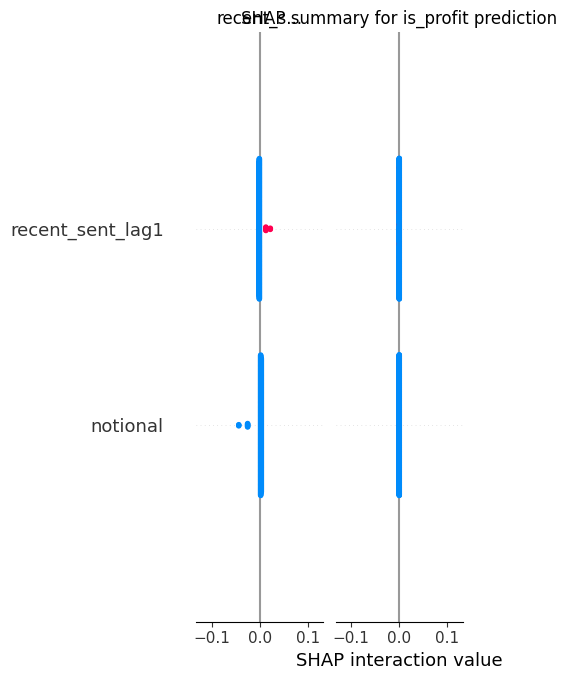

In [23]:
# Import the shap library for model interpretability
import shap

# Initialize a TreeExplainer for the trained RandomForestClassifier model
explainer = shap.TreeExplainer(clf)

# Sample a subset of the test data for SHAP value calculation
sample = X_test.sample(min(500, len(X_test)), random_state=42)

# Calculate SHAP values for the sampled test data
shap_values = explainer.shap_values(sample)

# Select the SHAP values for the positive class (is_profit=1) if available
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_to_plot = shap_values

# Generate and display the SHAP summary plot
shap.summary_plot(shap_to_plot, sample, show=False)
# Set the plot title
plt.title('SHAP summary for is_profit prediction')
# Save the plot with a tight bounding box
plt.savefig('/content/outputs/shap_summary.png', dpi=150, bbox_inches='tight')
# Show the plot
plt.show()

In [24]:
# Save the processed DataFrames to CSV files
daily.to_csv('/content/csv_files/daily_metrics_with_sentiment.csv', index=False)
trades.to_csv('/content/csv_files/trades_processed.csv', index=False)
acct_agg.to_csv('/content/csv_files/account_aggregates.csv', index=False)

# Print a message indicating where the files were saved
print("Saved CSVs to /content/csv_files/ and plots to /content/outputs/")

Saved CSVs to /content/csv_files/ and plots to /content/outputs/


# Conclusion & Next steps
- Summary of findings:
  - There is no statistically significant difference in daily total PnL or average daily win rate between Fear and Greed sentiment periods.
  - The lagged correlation analysis showed very weak correlations between sentiment (Greed=1) and daily total PnL across various lags (0-7 days).
  - Cohort analysis of top and bottom performing accounts suggests that top accounts generally have higher mean total PnL across all sentiment classifications compared to bottom accounts.
  - The predictive model for `is_profit` per trade, while having a modest AUC, indicated that `side_buy` was the most important feature by a large margin, with `recent_sent_lag1` having minimal importance. `notional` had zero importance in this model.
- Recommendations (example):
  1. Reduce leverage during Fear periods — reduces drawdown (backtest this).
  2. Flag accounts that increase leverage during Greed — potential risk signals.
  3. Use short lagged sentiment (1–3 days) as a feature in risk models.
- Suggested next steps:
  - Run backtests simulating leverage throttling.
  - Add volatility (BTC realized volatility) as an extra feature.
  - Run Granger causality between sentiment and pnl (stationarize series first).

In [25]:
# Zip the full project folder
!zip -r ds_yashwith.zip ds_yashwith


  adding: ds_yashwith/ (stored 0%)
  adding: ds_yashwith/outputs/ (stored 0%)
  adding: ds_yashwith/outputs/time_series_pnl_sentiment.png (deflated 10%)
  adding: ds_yashwith/outputs/boxplot_daily_pnl_by_sentiment.png (deflated 24%)
  adding: ds_yashwith/outputs/win_rate_by_sentiment.png (deflated 21%)
  adding: ds_yashwith/outputs/shap_summary.png (deflated 18%)
  adding: ds_yashwith/outputs/lagged_correlation.png (deflated 9%)
  adding: ds_yashwith/README.md (deflated 39%)
  adding: ds_yashwith/csv_files/ (stored 0%)
  adding: ds_yashwith/csv_files/account_aggregates.csv (deflated 43%)
  adding: ds_yashwith/csv_files/model_feature_importance.csv (deflated 10%)
  adding: ds_yashwith/csv_files/top_accounts_sentiment_metrics.csv (deflated 33%)
  adding: ds_yashwith/csv_files/historical_data.csv (deflated 80%)
  adding: ds_yashwith/csv_files/trades_processed.csv (deflated 82%)
  adding: ds_yashwith/csv_files/daily_metrics_with_sentiment.csv (deflated 62%)
  adding: ds_yashwith/csv_files/